#### By: Peyman Shahidi
#### Created: Oct 19, 2025
#### Last Edit: Oct 27, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects/execTypeVaryingDWA_anthropicIndex'
output_plot_path = f"{main_folder_path}/writeup/plots/anthropic_AI_index"

In [3]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [5]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,gpt4_exposure,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E2,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E2,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2


In [6]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


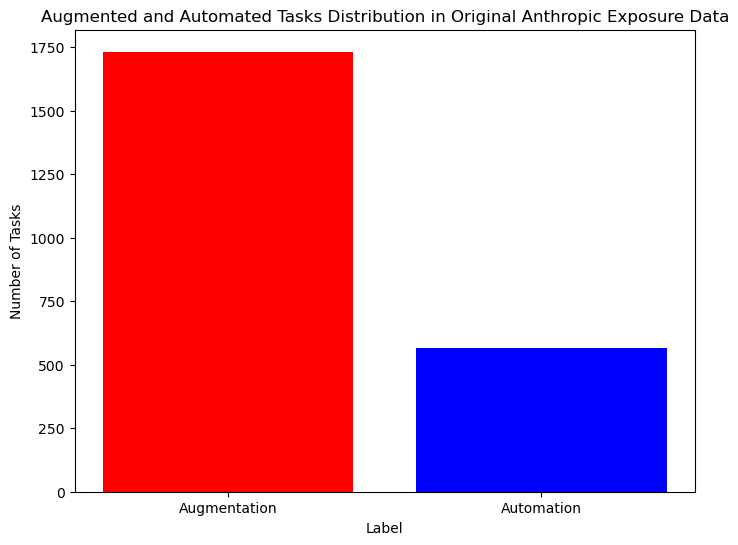

In [7]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]

# Plot histogram of the label column to see share of each label
label_counts = anthropic_exposure['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['red', 'blue'])
plt.title('Augmented and Automated Tasks Distribution in Original Anthropic Exposure Data')
plt.xlabel('Label')
plt.ylabel('Number of Tasks')
# plt.savefig(f'{output_plot_path}/anthropicIndex_automatedAugmented_taskDist.png')
plt.show()

In [8]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

merged_data.head()

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,task_normalized,task_name,automation,augmentation,label
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,NaN,NaN,direct or coordinate an organization's financi...,direct or coordinate an organization's financi...,0.35,0.57,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E0,E0,"confer with board members, organization offici...","confer with board members, organization offici...",0.25,0.61,Augmentation
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,analyze operations to evaluate performance of ...,analyze operations to evaluate performance of ...,0.31,0.66,Augmentation
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E0,"direct, plan, or implement policies, objective...",NaN,NaN,NaN,Manual
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,"prepare budgets for approval, including those ...",NaN,NaN,NaN,Manual


In [9]:
# Drop the supplemental tasks
merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [10]:
# Create occupation-level analysis for scatter plots
# Group by occupation and calculate label fractions and task counts
occupation_stats = []

for (soc_code, occ_title), group in merged_data.groupby(['O*NET-SOC Code', 'Occupation Title']):
    num_tasks = group['Task ID'].nunique()
    total_tasks = len(group)
    
    manual_fraction = (group['label'] == 'Manual').sum() / total_tasks
    augmentation_fraction = (group['label'] == 'Augmentation').sum() / total_tasks  
    automation_fraction = (group['label'] == 'Automation').sum() / total_tasks
    ai_fraction = augmentation_fraction + automation_fraction
    
    occupation_stats.append({
        'O*NET-SOC Code': soc_code,
        'Occupation Title': occ_title,
        'num_tasks': num_tasks,
        'manual_fraction': manual_fraction,
        'ai_fraction': ai_fraction,
        'augmentation_fraction': augmentation_fraction,
        'automation_fraction': automation_fraction
    })

occupation_analysis = pd.DataFrame(occupation_stats)

# save occupation analysis to CSV
occupation_analysis.to_csv(f'{output_data_path}/anthropic_occupationLevel_taskExposure_dataset.csv', index=False)

print(f"Number of occupations: {len(occupation_analysis):,}")
print(f"Range of tasks per occupation: {occupation_analysis['num_tasks'].min()} - {occupation_analysis['num_tasks'].max()}")
print(f"\nSample of occupation analysis:")
occupation_analysis.head(5)

Number of occupations: 837
Range of tasks per occupation: 1 - 38

Sample of occupation analysis:


,O*NET-SOC Code,Occupation Title,num_tasks,manual_fraction,ai_fraction,augmentation_fraction,automation_fraction
0,11-1011.00,Chief Executives,19,0.68,0.32,0.32,0.00
1,11-1011.03,Chief Sustainability Officers,18,0.72,0.28,0.28,0.00
2,11-1021.00,General and Operations Managers,9,0.89,0.11,0.11,0.00
3,11-2011.00,Advertising and Promotions Managers,13,0.85,0.15,0.15,0.00
4,11-2021.00,Marketing Managers,12,0.67,0.33,0.33,0.00


In [11]:
# Create Minor_Group_Code-level analysis
# Group by Minor_Group_Code and calculate label fractions and task counts
minor_group_stats = []

for (mg_code, mg_title), group in merged_data.groupby(['Minor_Group_Code', 'Minor_Group_Title']):
    num_tasks = group['Task ID'].nunique()
    num_occs = group['O*NET-SOC Code'].nunique()
    total_tasks = len(group)
    
    manual_fraction = (group['label'] == 'Manual').sum() / total_tasks
    augmentation_fraction = (group['label'] == 'Augmentation').sum() / total_tasks  
    automation_fraction = (group['label'] == 'Automation').sum() / total_tasks
    ai_fraction = augmentation_fraction + automation_fraction
    
    minor_group_stats.append({
        'Minor_Group_Code': mg_code,
        'Occupation Title': mg_title,
        'num_tasks': num_tasks,
        'num_occupations': num_occs,
        'manual_fraction': manual_fraction,
        'ai_fraction': ai_fraction,
        'augmentation_fraction': augmentation_fraction,
        'automation_fraction': automation_fraction
    })

minor_group_analysis = pd.DataFrame(minor_group_stats)

# save occupation analysis to CSV
minor_group_analysis.to_csv(f'{output_data_path}/anthropic_minorGroupLevel_taskExposure_dataset.csv', index=False)

print(f"Number of Minor Groups: {len(minor_group_analysis):,}")
print(f"Range of tasks per Minor Group: {minor_group_analysis['num_tasks'].min()} - {minor_group_analysis['num_tasks'].max()}")
print(f"\nSample of Minor Group analysis:")

# Sort Minor Groups by Fraction of Tasks to Occupations
minor_group_analysis['numTasks_to_numOccs_ratio'] = minor_group_analysis['num_tasks'] / minor_group_analysis['num_occupations']
minor_group_analysis = minor_group_analysis.sort_values(by='numTasks_to_numOccs_ratio', ascending=False).reset_index(drop=True)
minor_group_analysis.head(5)

Number of Minor Groups: 94
Range of tasks per Minor Group: 15 - 420

Sample of Minor Group analysis:


,Minor_Group_Code,Occupation Title,num_tasks,num_occupations,manual_fraction,ai_fraction,augmentation_fraction,automation_fraction,numTasks_to_numOccs_ratio
0,25-2000,"Preschool, Elementary, Middle, Secondary, and ...",362,11,0.72,0.28,0.08,0.20,32.91
1,45-3000,Fishing and Hunting Workers,27,1,1.00,0.00,0.00,0.00,27.00
2,45-1000,"Supervisors of Farming, Fishing, and Forestry ...",27,1,1.00,0.00,0.00,0.00,27.00
3,37-1000,Supervisors of Building and Grounds Cleaning a...,50,2,0.94,0.06,0.06,0.00,25.00
4,29-9000,Other Healthcare Practitioners and Technical O...,96,4,0.90,0.10,0.09,0.01,24.00


In [12]:
# # Regression: num_tasks on num_occupations with Major_Group_Code fixed effects
# # Create Major_Group_Code from Minor_Group_Code (first two characters)
# minor_group_analysis['Major_Group_Code'] = minor_group_analysis['Minor_Group_Code'].astype(str).str[:2]

# # Run OLS regression with fixed effects using statsmodels formula API
# import statsmodels.formula.api as smf
# model = smf.ols('num_occupations ~ num_tasks + C(Major_Group_Code)', data=minor_group_analysis).fit()

# # Print summary to output
# print(model.summary())

# # Save coefficients, standard errors and p-values to CSV
# coef_df = pd.DataFrame({
#     'coef': model.params,
#     'std_err': model.bse,
#     'p_value': model.pvalues
# }).reset_index().rename(columns={'index':'term'})
# coef_df.to_csv(f'{output_data_path}/majorGroup_numOccupation_on_numTasks_regression.csv', index=False)

# print('\nSaved coefficients to:', f"{output_data_path}/majorGroup_numOccupation_on_numTasks_regression.csv")

<br>

## Regress tasks of DWAs that have multiple execution types and see if previous/next tasks are indicators of AI-ability of task depending on location in the sequence

In [13]:
# If DWA columns were missing, bring them from original ONET file and recompute fractions
if 'DWA ID' not in merged_data.columns or 'DWA Title' not in merged_data.columns:
    print('DWA columns missing in merged_data; reading original ONET file to retrieve them')
    onet_dwa = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv', usecols=['Task ID','DWA ID','DWA Title'])
    onet_dwa = onet_dwa.drop_duplicates()
    merged_with_dwa = merged_data.merge(onet_dwa, on='Task ID', how='left')
    missing_dwa = merged_with_dwa['DWA ID'].isna().sum()
    print(f'Merged DWA columns in; rows with missing DWA after merge: {missing_dwa:,}')
    # Now group by DWA
    counts = merged_with_dwa.groupby(['DWA ID','DWA Title'])['label'].value_counts().unstack(fill_value=0).reset_index()
    for lbl in ['Manual','Automation','Augmentation']:
        if lbl not in counts.columns:
            counts[lbl] = 0
    counts['total'] = counts[['Manual','Automation','Augmentation']].sum(axis=1)
    counts['fraction_manual'] = counts['Manual'] / counts['total']
    counts['fraction_automation'] = counts['Automation'] / counts['total']
    counts['fraction_augmentation'] = counts['Augmentation'] / counts['total']
    counts[['fraction_manual','fraction_automation','fraction_augmentation']] = counts[['fraction_manual','fraction_automation','fraction_augmentation']].fillna(0)
    # Aggregate with unique counts
    agg = merged_with_dwa.groupby(['DWA ID','DWA Title']).agg(
        n_manual = ('label', lambda s: (s == 'Manual').sum()),
        n_automation = ('label', lambda s: (s == 'Automation').sum()),
        n_augmentation = ('label', lambda s: (s == 'Augmentation').sum()),
        num_tasks = ('Task ID', 'nunique'),
        num_occupations = ('O*NET-SOC Code', 'nunique')
    ).reset_index()
    agg['total'] = agg['n_manual'] + agg['n_automation'] + agg['n_augmentation']
    agg['fraction_manual'] = agg['n_manual'] / agg['total']
    agg['fraction_automation'] = agg['n_automation'] / agg['total']
    agg['fraction_augmentation'] = agg['n_augmentation'] / agg['total']
    agg[['fraction_manual','fraction_automation','fraction_augmentation']] = agg[['fraction_manual','fraction_automation','fraction_augmentation']].fillna(0)
    # Add AI fraction as sum of automation and augmentation fractions
    agg['fraction_ai'] = agg['fraction_automation'] + agg['fraction_augmentation']
    dwa_df = agg[['DWA ID','DWA Title','fraction_manual','fraction_automation','fraction_augmentation','fraction_ai','num_tasks','num_occupations']].copy()
    # Sort by fraction_ai descending
    dwa_df = dwa_df.sort_values(by=['fraction_ai', 'fraction_automation'], ascending=False).reset_index(drop=True)
    out_path = f'{output_data_path}/dwa_label_fraction_by_dwa.csv'
    dwa_df.to_csv(out_path, index=False)
    print('Saved DWA-level fractions to:', out_path)
    try:
        display(dwa_df.head())
    except Exception:
        print(dwa_df.head().to_string(index=False))
else:
    print('DWA columns already present; computing aggregates with existing columns')
    agg = merged_data.groupby(['DWA ID','DWA Title']).agg(
        n_manual = ('label', lambda s: (s == 'Manual').sum()),
        n_automation = ('label', lambda s: (s == 'Automation').sum()),
        n_augmentation = ('label', lambda s: (s == 'Augmentation').sum()),
        num_tasks = ('Task ID', 'nunique'),
        num_occupations = ('O*NET-SOC Code', 'nunique')
    ).reset_index()
    agg['total'] = agg['n_manual'] + agg['n_automation'] + agg['n_augmentation']
    agg['fraction_manual'] = agg['n_manual'] / agg['total']
    agg['fraction_automation'] = agg['n_automation'] / agg['total']
    agg['fraction_augmentation'] = agg['n_augmentation'] / agg['total']
    agg[['fraction_manual','fraction_automation','fraction_augmentation']] = agg[['fraction_manual','fraction_automation','fraction_augmentation']].fillna(0)
    # Add AI fraction as sum of automation and augmentation fractions
    agg['fraction_ai'] = agg['fraction_automation'] + agg['fraction_augmentation']
    dwa_df = agg[['DWA ID','DWA Title','fraction_manual','fraction_automation','fraction_augmentation','fraction_ai','num_tasks','num_occupations']].copy()
    # Sort by fraction_ai descending
    dwa_df = dwa_df.sort_values(by=['fraction_ai', 'fraction_automation'], ascending=False).reset_index(drop=True)
    out_path = f'{output_data_path}/dwa_label_fraction_by_dwa.csv'
    dwa_df.to_csv(out_path, index=False)
    print('Saved DWA-level fractions to:', out_path)
    try:
        display(dwa_df.head())
    except Exception:
        print(dwa_df.head().to_string(index=False))



# # Plot distribution of fraction_ai for DWAs
# import os
# csv_path = f'{output_data_path}/dwa_label_fraction_by_dwa.csv'
# if not os.path.exists(csv_path):
#     print('DWA CSV not found at', csv_path)
# else:
#     df = pd.read_csv(csv_path)
#     if 'fraction_ai' not in df.columns:
#         print('fraction_ai column not found in CSV')
#     else:
#         vals = df['fraction_ai'].dropna()
#         print('DWA count:', len(df))
#         print(vals.describe())
#         import matplotlib.pyplot as plt
#         try:
#             import seaborn as sns
#             use_sns = True
#         except Exception:
#             use_sns = False
#         plt.figure(figsize=(8,6))
#         plt.hist(vals, bins=30, color='C0', alpha=0.7, edgecolor='k')
#         if use_sns:
#             sns.kdeplot(vals, color='C1', lw=2)
#         mean = vals.mean()
#         median = vals.median()
#         plt.axvline(mean, color='red', linestyle='--', label=f'mean={mean:.2f}')
#         plt.axvline(median, color='green', linestyle='-', label=f'median={median:.2f}')
#         plt.title('Distribution of fraction_ai across DWAs')
#         plt.xlabel('fraction_ai')
#         plt.ylabel('Count')
#         plt.legend()
#         # out_fig = os.path.join(output_plot_path, 'dwa_fraction_ai_distribution.png')
#         plt.savefig(out_fig, dpi=150, bbox_inches='tight')
#         print('Saved plot to', out_fig)
#         plt.show()

DWA columns missing in merged_data; reading original ONET file to retrieve them
Merged DWA columns in; rows with missing DWA after merge: 285
Saved DWA-level fractions to: ../data/computed_objects/execTypeVaryingDWA_anthropicIndex/dwa_label_fraction_by_dwa.csv


,DWA ID,DWA Title,fraction_manual,fraction_automation,fraction_augmentation,fraction_ai,num_tasks,num_occupations
0,4.A.2.b.1.I07.D02,Edit documents.,0.00,1.00,0.00,1.00,1,1
1,4.A.2.b.2.I18.D02,Prepare production storyboards.,0.00,1.00,0.00,1.00,1,1
2,4.A.3.b.6.I12.D03,Create technology-based learning materials.,0.00,0.83,0.17,1.00,12,12
3,4.A.3.b.6.I02.D01,Prepare written decisions for legal proceedings.,0.00,0.75,0.25,1.00,4,3
4,4.A.2.b.2.I02.D04,Develop computer or online applications.,0.00,0.67,0.33,1.00,3,1


In [14]:
# Create a list of DWAs that have variation in terms of execution type
dwa_execTypeVarying_title_list = dwa_df[(dwa_df.fraction_ai < 1) & (dwa_df.fraction_ai > 0)]['DWA Title'].unique().tolist()
dwa_execTypeVarying_id_list = dwa_df[(dwa_df.fraction_ai < 1) & (dwa_df.fraction_ai > 0)]['DWA ID'].unique().tolist()

# Create a list of occupations that contain these execution-type varying
onet_dwa = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv', usecols=['O*NET-SOC Code', 'Occupation Title', 'DWA ID','DWA Title'])


dwa_execTypeVarying_occTitle_list = onet_dwa['Occupation Title'].unique().tolist()
dwa_execTypeVarying_occID_list = onet_dwa['O*NET-SOC Code'].unique().tolist()

In [15]:
# Read extract of data with task positions and AI measures
task_position_data = pd.read_csv(f'{input_data_path}/computed_objects/ONET_taskPosition_AImeasures.csv')
task_position_data['is_ai'] = task_position_data['label'].isin(['Augmentation','Automation']).astype(int)

# # Step 0: Randomize Task Position for sanity check
# task_position_data["Task Position"] = (
#     task_position_data.groupby("O*NET-SOC Code")["Task Position"]
#     .transform(lambda x: x.sample(frac=1, random_state=42).values))

# Step 1: Create flags for previous/next tasks is AI within occupation groups
# Sort by occupation and position when possible
task_position_data['Task Position'] = pd.to_numeric(task_position_data['Task Position'], errors='coerce')
task_position_data = task_position_data.sort_values(['O*NET-SOC Code', 'Task Position']).reset_index(drop=True)
group_col = 'O*NET-SOC Code'

# Compute neighbor flags (prev/next) within occupation groups when possible
task_position_data['prev_is_ai'] = 0
task_position_data['prev2_is_ai'] = 0
task_position_data['next_is_ai'] = 0
task_position_data['next2_is_ai'] = 0
pos_col = 'Task Position'

def _add_flags(df):
    df = df.sort_values('Task Position')
    df['prev_is_ai'] = df['is_ai'].shift(1).fillna(0).astype(int)
    df['prev2_is_ai'] = df['is_ai'].shift(2).fillna(0).astype(int)
    df['next_is_ai'] = df['is_ai'].shift(-1).fillna(0).astype(int)
    df['next2_is_ai'] = df['is_ai'].shift(-2).fillna(0).astype(int)
    return df
task_position_data = task_position_data.groupby(group_col, group_keys=False).apply(_add_flags).reset_index(drop=True)


# Step 2: Add back DWAs to the data
# Add back DWAs
onet_dwa = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv', usecols=['Task ID','DWA ID','DWA Title'])
onet_dwa = onet_dwa.drop_duplicates()
task_position_data = task_position_data.merge(onet_dwa, on='Task ID', how='left')

# Flag tasks whose DWA ID appears in dwa_execTypeVarying_id_list
task_position_data['dwa_execType_varying'] = task_position_data.get('DWA ID', pd.Series()).isin(dwa_execTypeVarying_id_list).fillna(False).astype(int)
print('Number of tasks flagged as execution-type-varying (1):', int(task_position_data['dwa_execType_varying'].sum()))
print(f'Fraction flagged: {task_position_data['dwa_execType_varying'].mean():.4f}')

# Summary for flagged DWA rows
mask = task_position_data['dwa_execType_varying'] == 1
n_flagged = int(mask.sum())
print(f'Number of dwa_execType_varying rows: {n_flagged}')
if n_flagged > 0:
    for c in ['prev2_is_ai', 'prev_is_ai', 'next_is_ai', 'next2_is_ai']:
        s = int(task_position_data.loc[mask, c].sum())
        frac = task_position_data.loc[mask, c].mean()
        print(f'{c}: {s} of {n_flagged} flagged rows (fraction={frac:.3f})')
    try:
        display(task_position_data.loc[mask].head())
    except Exception:
        print(task_position_data.loc[mask].head().to_string(index=False))
else:
    print('No flagged rows to summarize.')


Number of tasks flagged as execution-type-varying (1): 9586
Fraction flagged: 0.4305
Number of dwa_execType_varying rows: 9586
prev2_is_ai: 1688 of 9586 flagged rows (fraction=0.176)
prev_is_ai: 1841 of 9586 flagged rows (fraction=0.192)
next_is_ai: 1914 of 9586 flagged rows (fraction=0.200)
next2_is_ai: 1682 of 9586 flagged rows (fraction=0.175)


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,label,Task Position,is_ai,prev_is_ai,prev2_is_ai,next_is_ai,next2_is_ai,DWA ID,DWA Title,dwa_execType_varying
0,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or publi...",Core,5,2.12,124.47,38.46,62.90,...,Augmentation,1.00,1,0,0,0,1,4.A.2.a.4.I09.D03,Analyze impact of legal or regulatory changes.,1
1,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or publi...",Core,5,2.12,124.47,38.46,62.90,...,Augmentation,1.00,1,0,0,0,1,4.A.4.b.6.I08.D04,Advise others on legal or regulatory complianc...,1
3,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,Augmentation,3.00,1,0,1,1,0,4.A.2.a.4.I07.D09,Analyze data to assess operational or project ...,1
4,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,Augmentation,4.00,1,1,0,0,0,4.A.4.a.2.I03.D14,Confer with organizational members to accompli...,1
6,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,Manual,6.00,0,0,1,1,0,4.A.2.b.1.I09.D01,Implement organizational process or policy cha...,1


In [16]:
# Regressions: neighbor flags on is_ai (Logit, no FE + several FE models)
# Assumption: dependent variable = 'is_ai' and regressors are the four neighbor flags
# (prev2_is_ai, prev_is_ai, next_is_ai, next2_is_ai).
# Runs on full `task_position_data` and on filtered subset where dwa_execType_varying==1.

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from pathlib import Path
from statsmodels.stats.sandwich_covariance import cov_hc1
from scipy.stats import norm

# ------- config / safe defaults -------
try:
    output_data_path  # if already defined upstream, keep it
except NameError:
    output_data_path = "./outputs"

# Variables of interest
TARGET_REGS = ['prev2_is_ai','prev_is_ai','next_is_ai','next2_is_ai']

# ------- helpers -------
# Extract params, robust SEs (HC1) and model sample/df info
def extract_coef_series(res):
    try:
        if hasattr(res, 'get_robustcov_results'):
            r = res.get_robustcov_results(cov_type='HC1')
            nobs = getattr(r, 'nobs', getattr(res, 'nobs', np.nan))
            df_resid = getattr(r, 'df_resid', getattr(res, 'df_resid', np.nan))
            return r.params, r.bse, r.pvalues, nobs, df_resid
        else:
            params = res.params
            try:
                robust_cov = cov_hc1(res)
                bse_arr = np.sqrt(np.diag(robust_cov))
                z_scores = params.values / bse_arr
                pvals = 2 * (1 - norm.cdf(np.abs(z_scores)))
                bse = pd.Series(bse_arr, index=params.index)
                pvalues = pd.Series(pvals, index=params.index)
                nobs = getattr(res, 'nobs', np.nan)
                df_resid = getattr(res, 'df_resid', np.nan)
                return params, bse, pvalues, nobs, df_resid
            except Exception:
                bse = getattr(res, 'bse', pd.Series(np.nan, index=params.index))
                pvalues = getattr(res, 'pvalues', pd.Series(np.nan, index=params.index))
                nobs = getattr(res, 'nobs', np.nan)
                df_resid = getattr(res, 'df_resid', np.nan)
                return params, bse, pvalues, nobs, df_resid
    except Exception:
        params = getattr(res, 'params', pd.Series())
        bse = getattr(res, 'bse', pd.Series())
        pvalues = getattr(res, 'pvalues', pd.Series())
        nobs = getattr(res, 'nobs', np.nan)
        df_resid = getattr(res, 'df_resid', np.nan)
        return params, bse, pvalues, nobs, df_resid

# Build tidy coef dataframe for target regs
def build_tidy_coefs(res, dataset_name, model_name):
    params, bse, pvalues, nobs, df_resid = extract_coef_series(res)
    if len(params) == 0:
        return pd.DataFrame(columns=['dataset','model','term','coef','std_err','p_value','nobs','df_resid'])
    df = pd.DataFrame({
        'term': params.index.astype(str),
        'coef': params.values,
        'std_err': bse.values if hasattr(bse, 'values') else np.array(bse),
        'p_value': pvalues.values if hasattr(pvalues, 'values') else np.array(pvalues)
    })
    df['model'] = model_name
    df['dataset'] = dataset_name
    df['nobs'] = nobs
    df['df_resid'] = df_resid
    df = df[df['term'].isin(TARGET_REGS)].reset_index(drop=True)
    df = df[['dataset','model','nobs','df_resid','term','coef','std_err','p_value']]
    return df

# Drop FE groups with no within-group variation in y or too small size
def keep_var_groups(df, fe_col, y="is_ai", min_size=2):
    return df.groupby(fe_col).filter(lambda g: g[y].nunique() == 2 and len(g) >= min_size)

# Core function to run requested regressions on a DataFrame
def run_regressions_on(df, dataset_name):
    df = df.copy()

    # make sure regressors and outcome exist and are numeric
    regs = TARGET_REGS
    for r in regs + ['is_ai']:
        if r not in df.columns:
            raise KeyError(f'Required column {r} not found in dataset {dataset_name}')
    df[regs] = df[regs].apply(pd.to_numeric, errors='coerce').fillna(0)
    df['is_ai'] = pd.to_numeric(df['is_ai'], errors='coerce').fillna(0)

    base_formula = 'is_ai ~ prev2_is_ai + prev_is_ai + next_is_ai + next2_is_ai'
    models = {}
    tidy_list = []

    # 1) No fixed effects (Logit)
    # print(f'Running NO-FE logit model on {dataset_name}...')
    try:
        res_no_fe = smf.logit(base_formula, data=df).fit(disp=False)
        models['no_fe'] = res_no_fe
        tidy_list.append(build_tidy_coefs(res_no_fe, dataset_name, 'no_fe'))
        # try:
        #     print(res_no_fe.summary())
        # except Exception:
        #     print('Estimated NO-FE logit model (summary not available)')
    except Exception as e:
        print('No-FE logit model failed:', e)

    # 2) Fixed effects models (each separately)
    fe_cols = [
        ('Major_Group_Code','MajorGroup'),
        ('Minor_Group_Code','MinorGroup'),
        ('Broad_Occupation_Code','BroadOcc'),
        ('Detailed_Occupation_Code','DetailedOcc')
    ]

    for col, short in fe_cols:
        formula = base_formula + f' + C({col})'
        # print(f'Running FE logit model with {col} on {dataset_name}...')

        # Drop problematic FE groups for THIS FE
        df_fe = keep_var_groups(df, col, y="is_ai", min_size=2)
        kept = df_fe[col].nunique()
        dropped = df[col].nunique() - kept
        # print(f'  Filtered FE groups: kept {kept} (dropped {dropped})')

        try:
            res = smf.logit(formula, data=df_fe).fit(disp=False)
            models[f'fe_{short}'] = res
            tidy_list.append(build_tidy_coefs(res, dataset_name, f'fe_{short}'))
            # try:
            #     print(res.summary())
            # except Exception:
            #     print(f'Estimated FE logit model with {col} (summary not available)')
        except Exception as e:
            print(f'FE logit model with {col} failed:', e)
            # Optional fallback (uncomment to try penalized fit when separation persists)
            # try:
            #     res_reg = smf.logit(formula, data=df_fe).fit_regularized(method='l1', alpha=1.0, disp=False)
            #     models[f'fe_{short}_reg'] = res_reg
            #     tidy_list.append(build_tidy_coefs(res_reg, dataset_name, f'fe_{short}_reg'))
            #     print(f'  -> Used L1-regularized fit for {col}')
            # except Exception as e2:
            #     print(f'  Penalized fit also failed for {col}:', e2)

    # Combine tidy coeffs for this dataset
    if len(tidy_list):
        tidy_combined = pd.concat(tidy_list, ignore_index=True)
    else:
        tidy_combined = pd.DataFrame(columns=['dataset','model','nobs','df_resid','term','coef','std_err','p_value'])

    # Save per-dataset four-variable summary
    out_dir = Path(f'{output_data_path}/regression_summaries')
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f'regression_{dataset_name}_fourvars_summary.csv'
    tidy_combined.to_csv(out_path, index=False)
    # print(f'Saved per-dataset four-variable summary to {out_path}')

    return models, tidy_combined

# ----------------- run -----------------
print('Starting regressions on full task_position_data')
models_full, coefs_full = run_regressions_on(task_position_data, 'full_task_position_data')

print('\nStarting regressions on filtered dataset (dwa_execType_varying == 1)')
filtered = task_position_data[task_position_data['dwa_execType_varying'] == 1].reset_index(drop=True)
models_filtered, coefs_filtered = run_regressions_on(filtered, 'filtered_dwaExecTypeVarying')

combined_all = pd.concat([coefs_full, coefs_filtered], ignore_index=True)
final_out = Path(output_data_path) / 'regression_fourvars_allDatasets.csv'
combined_all.to_csv(final_out, index=False)
print(f'Combined four-variable CSV saved to {final_out}')

Starting regressions on full task_position_data

Starting regressions on filtered dataset (dwa_execType_varying == 1)
Combined four-variable CSV saved to ../data/computed_objects/execTypeVaryingDWA_anthropicIndex/regression_fourvars_allDatasets.csv


Computing observed coefficients (original ordering)
Running up to 500 reshuffles; skipping seeds with existing summaries (if any)
  Seed 0: loaded existing results (skipped computation)
  Seed 1: loaded existing results (skipped computation)
  Seed 2: loaded existing results (skipped computation)
  Seed 3: loaded existing results (skipped computation)
  Seed 4: loaded existing results (skipped computation)
  Seed 5: loaded existing results (skipped computation)
  Seed 6: loaded existing results (skipped computation)
  Seed 7: loaded existing results (skipped computation)
  Seed 8: loaded existing results (skipped computation)
  Seed 9: loaded existing results (skipped computation)
  Completed 10/500 seeds processed
  Seed 10: loaded existing results (skipped computation)
  Seed 11: loaded existing results (skipped computation)
  Seed 12: loaded existing results (skipped computation)
  Seed 13: loaded existing results (skipped computation)
  Seed 14: loaded existing results (skipped com

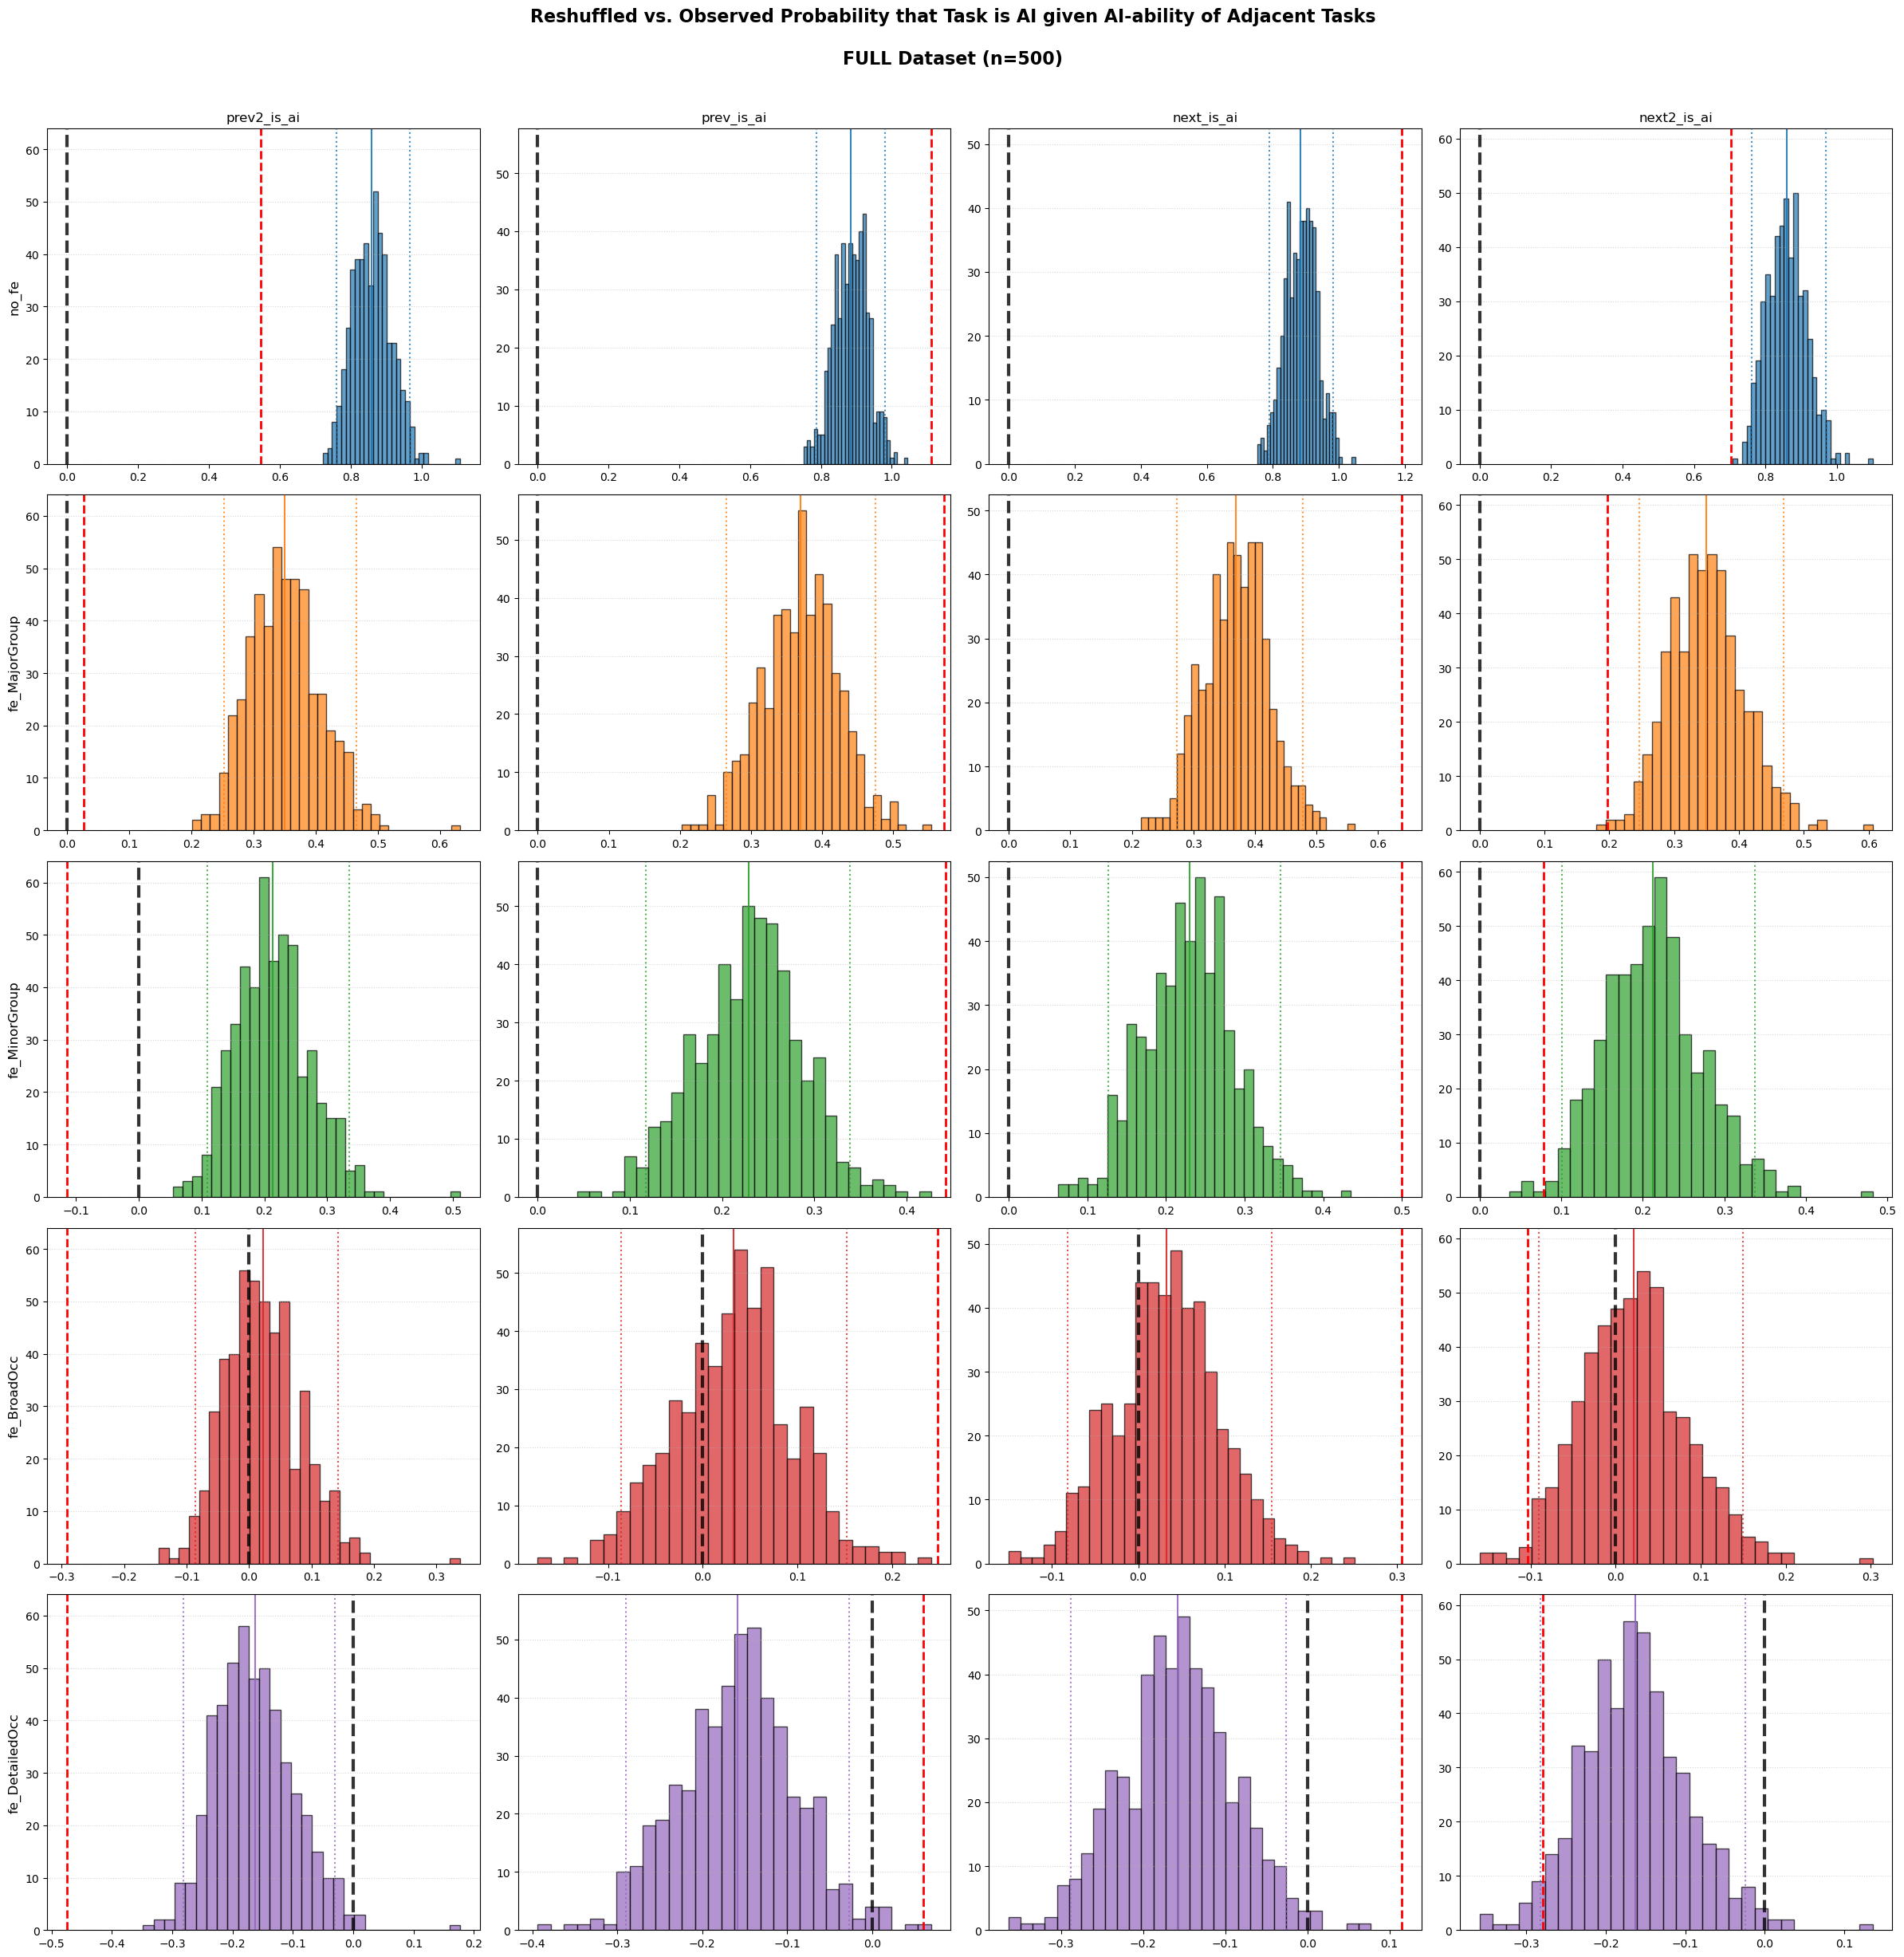

Saved plot to ../writeup/plots/anthropic_AI_index/adjacentTask_AIability_regressionCoeffs_filtered.png


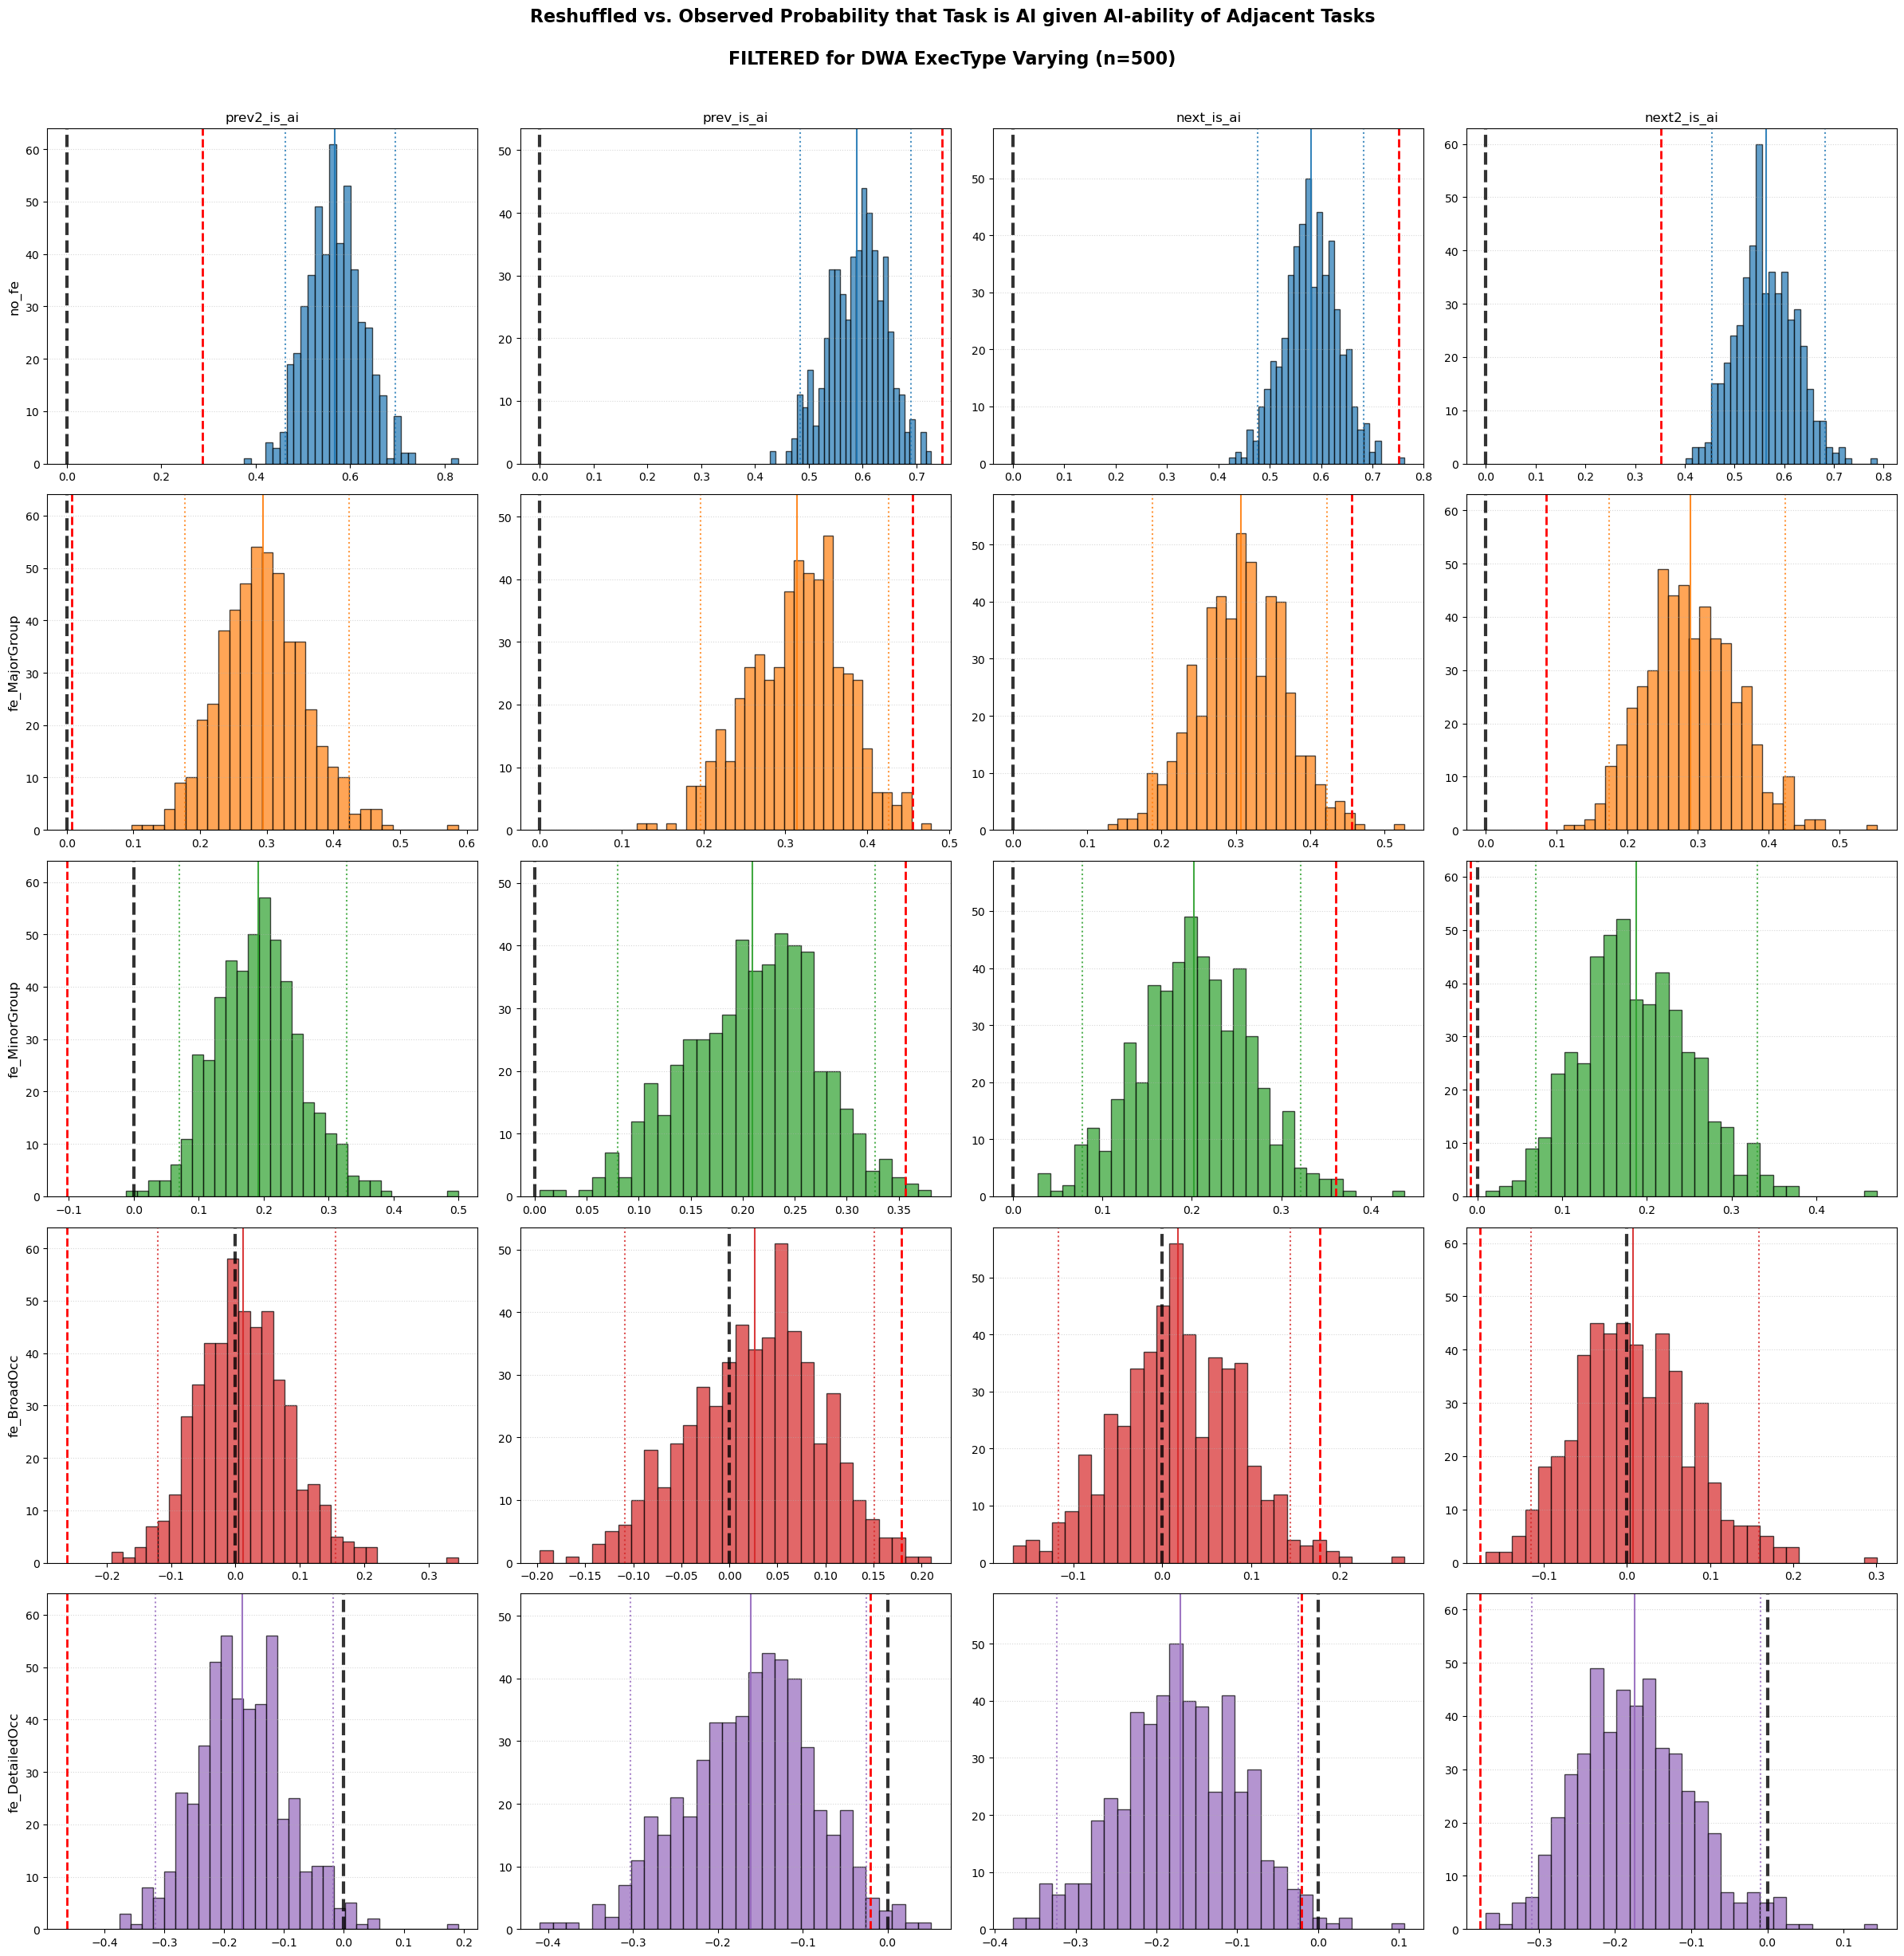

All done: comparative histogram figures created for full and filtered datasets


In [17]:
# --- Reshuffle-based placebo regressions and plots ---
# Re-run the neighbor-flag regressions on multiple reshuffles of Task Position
# and compare observed coefficients to reshuffled distributions for two datasets
# (full and filtered (dwa_execType_varying==1)).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Number of reshuffles (adjust for speed vs precision)
n_shuffles = 500

# Terms and specs to collect (must match earlier TARGET_REGS and FE naming)
TERMS = ['prev2_is_ai','prev_is_ai','next_is_ai','next2_is_ai']
SPECS = ['no_fe','fe_MajorGroup','fe_MinorGroup','fe_BroadOcc','fe_DetailedOcc']

# Helper: compute neighbor flags (same logic as earlier cell)
def add_neighbor_flags(df):
    df = df.copy()
    df['Task Position'] = pd.to_numeric(df['Task Position'], errors='coerce')
    df = df.sort_values(['O*NET-SOC Code','Task Position']).reset_index(drop=True)
    def _add_flags(g):
        g = g.sort_values('Task Position')
        g['prev_is_ai'] = g['is_ai'].shift(1).fillna(0).astype(int)
        g['prev2_is_ai'] = g['is_ai'].shift(2).fillna(0).astype(int)
        g['next_is_ai'] = g['is_ai'].shift(-1).fillna(0).astype(int)
        g['next2_is_ai'] = g['is_ai'].shift(-2).fillna(0).astype(int)
        return g
    df = df.groupby('O*NET-SOC Code', group_keys=False).apply(_add_flags).reset_index(drop=True)
    return df

# Ensure we have the baseline objects from the main analysis
try:
    task_position_data
except NameError:
    raise RuntimeError('task_position_data not found in the notebook state; run earlier cells first')

# Compute observed (non-reshuffled) coefficients for full and filtered datasets
print('Computing observed coefficients (original ordering)')
obs_models_full, obs_coefs_full = run_regressions_on(task_position_data, 'obs_full')
filtered_obs = task_position_data[task_position_data['dwa_execType_varying'] == 1].reset_index(drop=True)
obs_models_filt, obs_coefs_filt = run_regressions_on(filtered_obs, 'obs_filtered')

# Convert tidy dataframes to nested dicts for easy lookup
def tidy_to_dict(tidy_df):
    out = {spec: {term: np.nan for term in TERMS} for spec in SPECS}
    for _, row in tidy_df.iterrows():
        spec = row['model']
        term = row['term']
        if spec in out and term in out[spec]:
            out[spec][term] = row['coef']
    return out

obs_dict_full = tidy_to_dict(obs_coefs_full)
obs_dict_filt = tidy_to_dict(obs_coefs_filt)

# Prepare containers for reshuffled coefficients
resh_full = {spec: {t: [] for t in TERMS} for spec in SPECS}
resh_filt = {spec: {t: [] for t in TERMS} for spec in SPECS}

# Directory where per-seed regression summaries are saved by run_regressions_on
out_dir = Path(f"{output_data_path}/regression_summaries")
out_dir.mkdir(parents=True, exist_ok=True)

print(f'Running up to {n_shuffles} reshuffles; skipping seeds with existing summaries (if any)')
for i in range(n_shuffles):
    seed = 1000 + i
    # expected filenames produced by run_regressions_on
    fname_full = out_dir / f'regression_shuf_full_{i}_fourvars_summary.csv'
    fname_filt = out_dir / f'regression_shuf_filt_{i}_fourvars_summary.csv'

    # If both files exist, load them instead of re-running regressions
    if fname_full.exists() and fname_filt.exists():
        try:
            coefs_shuf_full = pd.read_csv(fname_full)
            coefs_shuf_filt = pd.read_csv(fname_filt)
            print(f'  Seed {i}: loaded existing results (skipped computation)')
        except Exception as e:
            print(f'  Seed {i}: failed to load existing CSVs, will recompute: {e}')
            coefs_shuf_full = pd.DataFrame()
            coefs_shuf_filt = pd.DataFrame()
    else:
        # shuffle Task Position within each occupation
        df_shuf = task_position_data.copy()
        df_shuf['Task Position'] = df_shuf.groupby('O*NET-SOC Code')['Task Position'].transform(lambda x: x.sample(frac=1, random_state=seed).values)
        # recompute neighbor flags
        df_shuf = add_neighbor_flags(df_shuf)

        # Run regressions on full shuffled data (will save summary inside run_regressions_on)
        try:
            _, coefs_shuf_full = run_regressions_on(df_shuf, f'shuf_full_{i}')
        except Exception as e:
            print(f'  Shuffle {i}: run_regressions_on failed on full dataset: {e}')
            coefs_shuf_full = pd.DataFrame(columns=['dataset','model','nobs','df_resid','term','coef','std_err','p_value'])

        # Run regressions on filtered shuffled subset
        df_shuf_filt = df_shuf[df_shuf['dwa_execType_varying'] == 1].reset_index(drop=True)
        try:
            _, coefs_shuf_filt = run_regressions_on(df_shuf_filt, f'shuf_filt_{i}')
        except Exception as e:
            print(f'  Shuffle {i}: run_regressions_on failed on filtered dataset: {e}')
            coefs_shuf_filt = pd.DataFrame(columns=['dataset','model','nobs','df_resid','term','coef','std_err','p_value'])

        # Ensure CSVs exist after run_regressions_on; try to read if not in memory
        if coefs_shuf_full.empty and fname_full.exists():
            try:
                coefs_shuf_full = pd.read_csv(fname_full)
            except Exception:
                pass
        if coefs_shuf_filt.empty and fname_filt.exists():
            try:
                coefs_shuf_filt = pd.read_csv(fname_filt)
            except Exception:
                pass

    # Convert tidy results to dicts and append
    d_full = tidy_to_dict(coefs_shuf_full) if not coefs_shuf_full.empty else tidy_to_dict(pd.DataFrame())
    d_filt = tidy_to_dict(coefs_shuf_filt) if not coefs_shuf_filt.empty else tidy_to_dict(pd.DataFrame())
    for spec in SPECS:
        for t in TERMS:
            resh_full[spec][t].append(d_full.get(spec, {}).get(t, np.nan))
            resh_filt[spec][t].append(d_filt.get(spec, {}).get(t, np.nan))

    if (i+1) % 10 == 0:
        print(f'  Completed {i+1}/{n_shuffles} seeds processed')

print('Reshuffles (and loads) complete; creating comparative plots')

# Plotting function for a dataset (reshuffled histogram vs observed)
def plot_comparison_hist(resh_dict, obs_dict, title, out_name, bins=30):
    # assign a distinct color per row/spec
    colors = [plt.cm.tab10(i % 10) for i in range(len(SPECS))]
    fig, axes = plt.subplots(nrows=len(SPECS), ncols=len(TERMS), figsize=(24, 25), sharey='col')

    for r, spec in enumerate(SPECS):
        color_row = colors[r]
        for c, term in enumerate(TERMS):
            ax = axes[r, c] if len(SPECS) > 1 else axes[c]
            vals = np.array(resh_dict[spec][term], dtype=float)
            vals_clean = vals[~np.isnan(vals)]

            if len(vals_clean):
                ax.hist(vals_clean, bins=bins, color=color_row, alpha=0.7, edgecolor='k')

                # plot 95% CI from reshuffles
                lo = np.percentile(vals_clean, 2.5)
                hi = np.percentile(vals_clean, 97.5)
                ax.axvline(lo, color=color_row, linestyle=':', alpha=0.8)
                ax.axvline(hi, color=color_row, linestyle=':', alpha=0.8)

                # plot mean of reshuffles
                ax.axvline(np.mean(vals_clean), color=color_row, linestyle='-', alpha=0.9)
            else:
                ax.text(0.5, 0.5, 'no estimates', ha='center', va='center')

            # always highlight x=0 line
            ax.axvline(0.0, color='black', linestyle='--', linewidth=3, alpha=0.8, label='zero')

            # observed coefficient (thicker red dashed line)
            obs_val = obs_dict.get(spec, {}).get(term, np.nan)
            if not np.isnan(obs_val):
                ax.axvline(obs_val, color='red', linestyle='--', linewidth=2, label='observed')

            if r == 0:
                ax.set_title(term, fontsize=12)
            if c == 0:
                ax.set_ylabel(spec, fontsize=12)
            ax.grid(axis='y', linestyle=':', alpha=0.5)

    fig.suptitle(f'Reshuffled vs. Observed Probability that Task is AI given AI-ability of Adjacent Tasks\n\n' + title, 
                 fontsize=16, fontweight='bold')
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    out_path = Path(output_plot_path) / out_name
    fig.savefig(out_path, dpi=150, bbox_inches='tight')
    print('Saved plot to', out_path)
    plt.show()

# Create plots for full and filtered datasets
Path(output_plot_path).mkdir(parents=True, exist_ok=True)
plot_comparison_hist(resh_full, obs_dict_full, f'FULL Dataset (n={n_shuffles})', 'adjacentTask_AIability_regressionCoeffs_full.png')
plot_comparison_hist(resh_filt, obs_dict_filt, f'FILTERED for DWA ExecType Varying (n={n_shuffles})', 'adjacentTask_AIability_regressionCoeffs_filtered.png')

print('All done: comparative histogram figures created for full and filtered datasets')
